In [1]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.8 MB/s eta 0:00:00


In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

# Define dataset + project folder in Drive
PROJECT_DIR = "/content/drive/MyDrive/YOLO_LicensePlate"
DATASET_DIR = f"{PROJECT_DIR}/datasets/license_plate"

# Create directories if not exist
os.makedirs(DATASET_DIR, exist_ok=True)
print("Project folder created at:", PROJECT_DIR)


Project folder created at: /content/drive/MyDrive/YOLO_LicensePlate


In [5]:
!pip install ultralytics
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/car-plate-detection")

print("Path to dataset files:", path)


100%|██████████| 203M/203M [00:10<00:00, 20.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/car-plate-detection/versions/1


In [7]:
import os
print("Dataset Path:", path)
print("Files:", os.listdir(path))


Dataset Path: /root/.cache/kagglehub/datasets/andrewmvd/car-plate-detection/versions/1
Files: ['annotations', 'images']


In [10]:
import os
print("Path:", path)
print(os.listdir(path))


Path: /root/.cache/kagglehub/datasets/andrewmvd/car-plate-detection/versions/1
['annotations', 'images']


In [11]:
import os
import xml.etree.ElementTree as ET

# Input/Output paths
dataset_path = "/root/.cache/kagglehub/datasets/andrewmvd/car-plate-detection/versions/1"
ann_dir = os.path.join(dataset_path, "annotations")
img_dir = os.path.join(dataset_path, "images")

# Output YOLO structure
yolo_base = "/content/datasets/car_plate"
os.makedirs(f"{yolo_base}/images/train", exist_ok=True)
os.makedirs(f"{yolo_base}/images/val", exist_ok=True)
os.makedirs(f"{yolo_base}/labels/train", exist_ok=True)
os.makedirs(f"{yolo_base}/labels/val", exist_ok=True)

# Simple split: 80% train, 20% val
import glob, shutil
from sklearn.model_selection import train_test_split

all_images = glob.glob(os.path.join(img_dir, "*.png")) + glob.glob(os.path.join(img_dir, "*.jpg"))
train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

def convert_xml_to_yolo(xml_file, img_w, img_h):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    yolo_data = []
    for obj in root.findall("object"):
        label = obj.find("name").text
        # Only one class: license plate
        class_id = 0
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # Convert to YOLO format (normalized)
        x_center = (xmin + xmax) / 2.0 / img_w
        y_center = (ymin + ymax) / 2.0 / img_h
        width = (xmax - xmin) / img_w
        height = (ymax - ymin) / img_h

        yolo_data.append(f"{class_id} {x_center} {y_center} {width} {height}")
    return yolo_data

import cv2

def process_split(img_list, split):
    for img_path in img_list:
        file_name = os.path.basename(img_path)
        xml_path = os.path.join(ann_dir, file_name.replace(".png", ".xml").replace(".jpg", ".xml"))

        if not os.path.exists(xml_path):
            continue

        # Get image size
        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        # Convert XML → YOLO txt
        yolo_labels = convert_xml_to_yolo(xml_path, w, h)

        # Save in YOLO structure
        shutil.copy(img_path, f"{yolo_base}/images/{split}/{file_name}")
        label_path = os.path.join(f"{yolo_base}/labels/{split}", file_name.replace(".png", ".txt").replace(".jpg", ".txt"))
        with open(label_path, "w") as f:
            f.write("\n".join(yolo_labels))

process_split(train_imgs, "train")
process_split(val_imgs, "val")

print("✅ Conversion complete. YOLO dataset ready at:", yolo_base)


✅ Conversion complete. YOLO dataset ready at: /content/datasets/car_plate


In [15]:
data_yaml = """
train: /content/datasets/car_plate/images/train
val: /content/datasets/car_plate/images/val

nc: 1
names: ['license_plate']
"""

with open("/content/datasets/car_plate/data.yaml", "w") as f:
    f.write(data_yaml)

print("✅ data.yaml created at /content/datasets/car_plate/data.yaml")


✅ data.yaml created at /content/datasets/car_plate/data.yaml


In [16]:
from ultralytics import YOLO
import pandas as pd

# Load YOLOv8 small pretrained model
model = YOLO("yolov8s.pt")

# Train
results = model.train(
    data="/content/datasets/car_plate/data.yaml",  # ✅ now exists
    epochs=30,
    imgsz=640,
    batch=16
)

# Load training log
csv_path = results.save_dir / "results.csv"
df = pd.read_csv(csv_path)

# Print accuracy every 5 epochs
for i, row in df.iterrows():
    epoch_num = int(row['epoch']) + 1
    if epoch_num % 5 == 0:
        print(f"Epoch {epoch_num:02d}: mAP50 = {row['metrics/mAP50(B)']:.4f}")


Ultralytics 8.3.190 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/car_plate/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, 

In [18]:
from google.colab import files
files.download("runs/detect/train5/weights/best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import shutil
shutil.copy("runs/detect/train5/weights/best.pt", "ANPR.pt")

from google.colab import files
files.download("ANPR.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

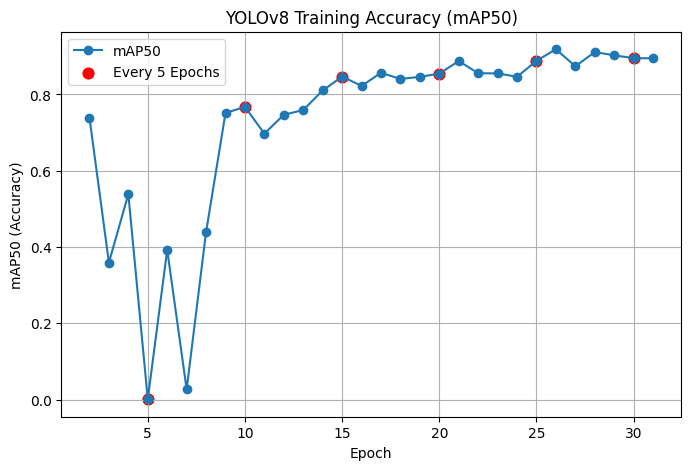

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load YOLO training log
csv_path = "runs/detect/train5/results.csv"
df = pd.read_csv(csv_path)

# Plot mAP50 curve
plt.figure(figsize=(8,5))
plt.plot(df["epoch"]+1, df["metrics/mAP50(B)"], marker="o", label="mAP50")

# Highlight every 5 epochs
five_epochs = df[df["epoch"].isin([4,9,14,19,24,29])]
plt.scatter(five_epochs["epoch"]+1, five_epochs["metrics/mAP50(B)"], color="red", s=60, label="Every 5 Epochs")

plt.xlabel("Epoch")
plt.ylabel("mAP50 (Accuracy)")
plt.title("YOLOv8 Training Accuracy (mAP50)")
plt.legend()
plt.grid(True)
plt.show()
